## Pre processing dei dati

In [2]:
import torch
import numpy as np
np.random.seed(1122)
torch.cuda.random.manual_seed(1122)
print(torch.cuda.is_available())

False


In [3]:
path_dataset = "../dataset/"
path_modelli = "../modelli"
path_logs = "../logs"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\giova\PythonEnvs\ml_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


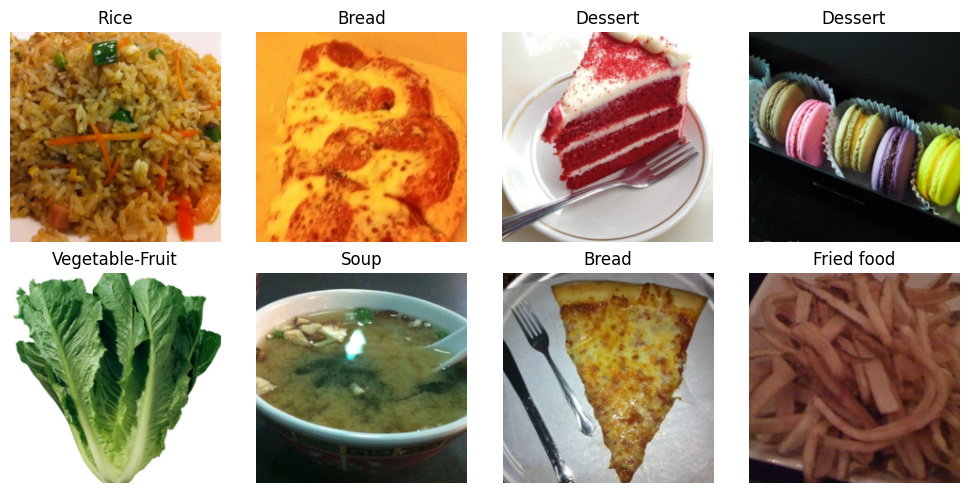

In [4]:
# Stampa di campioni casuali di immagini di training

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=os.path.join(path_dataset, "training"),
    transform = transform_train
)


train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True,num_workers=0, pin_memory=True)

images, labels = next(iter(train_loader))


fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()

for img, label, ax in zip(images[:8], labels[:8], axes):
    
    # Da (C, H, W) → (H, W, C)
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    
    class_name = train_dataset.classes[label]
    ax.set_title(f"{class_name}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [5]:
# Preparazione del dataset

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


# Creiamo i dataset per training, evaluation e validation
train_dataset = datasets.ImageFolder(
    root=os.path.join(path_dataset, "training"),
    transform=transform_train
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(path_dataset, "validation"),
    transform=transform_test
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(path_dataset, "test"),
    transform=transform_test
)

class_names = train_dataset.classes
print("Classi trovate:",class_names )

# Creazione dei data loader
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True,num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle=False,num_workers= 0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False,num_workers=0,pin_memory=True)

Classi trovate: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [6]:
# Conteggio campioni del dataset per classe

from collections import Counter

def count_images_per_class(dataset, dataset_name):
    tot = 0
    counter = Counter(dataset.targets)
    print(f"Distribuzione nel dataset {dataset_name}:")
    for class_idx, num_images in sorted(counter.items()):
        class_name = dataset.classes[class_idx]
        tot +=  num_images
        print(f" - Classe '{class_name}': {num_images} immagini")
    print(f"Totale immagini nel dataset {dataset_name} = {tot}")
    print()

# Calcola distribuzioni sui tre dataset
count_images_per_class(train_dataset, "Training")
count_images_per_class(val_dataset, "Validation")
count_images_per_class(test_dataset, "Test")

Distribuzione nel dataset Training:
 - Classe 'Bread': 1776 immagini
 - Classe 'Dairy product': 1650 immagini
 - Classe 'Dessert': 2486 immagini
 - Classe 'Egg': 1620 immagini
 - Classe 'Fried food': 1446 immagini
 - Classe 'Meat': 2323 immagini
 - Classe 'Noodles-Pasta': 1515 immagini
 - Classe 'Rice': 1572 immagini
 - Classe 'Seafood': 1477 immagini
 - Classe 'Soup': 2257 immagini
 - Classe 'Vegetable-Fruit': 2484 immagini
Totale immagini nel dataset Training = 20606

Distribuzione nel dataset Validation:
 - Classe 'Bread': 300 immagini
 - Classe 'Dairy product': 300 immagini
 - Classe 'Dessert': 300 immagini
 - Classe 'Egg': 300 immagini
 - Classe 'Fried food': 300 immagini
 - Classe 'Meat': 300 immagini
 - Classe 'Noodles-Pasta': 300 immagini
 - Classe 'Rice': 300 immagini
 - Classe 'Seafood': 300 immagini
 - Classe 'Soup': 300 immagini
 - Classe 'Vegetable-Fruit': 300 immagini
Totale immagini nel dataset Validation = 3300

Distribuzione nel dataset Test:
 - Classe 'Bread': 100 imm

## Definizione delle procedure di train, test e valutazione


In [7]:
class AverageValueMeter():
  def __init__(self):
    self.reset()

  def reset(self):
    self.sum = 0
    self.num = 0

  def add(self,value,num):
    self.sum += value*num
    self.num += num

  def value(self):
    try:
      return self.sum/self.num
    except:
      return None

In [8]:
# procedura di training 
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, f1_score
from os.path import join
import torch.nn as nn


def train_classifier(model, train_loader, val_loader, exp_name = 'experiment', lr = 0.01, epochs = 10, momentum = 0.99, criterion = None, weight_decay = 0, logdir = 'logs'):
  
  # funzione di loss (possibilità di selezionare manualmente la funzione di loss preferita)
  if criterion is None:
    criterion = nn.CrossEntropyLoss() 
  else:
    criterion = criterion
 
  optimizer = SGD(model.parameters(), lr, momentum = momentum, weight_decay = weight_decay) # funzione di learning

  loss_meter = AverageValueMeter()
  acc_meter = AverageValueMeter()

  # writer
  writer = SummaryWriter(join(path_logs,exp_name))

  # device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model.to(device)

  # definiamo un dizionario contenente i loader di training e test
  loader = {
      'train': train_loader,
      'val': val_loader
  }

  # inizializziamo il global step
  global_step = 0
  
  # inizializzaimo la best acc e la corrispondente epoca
  best_acc = 0
  best_epoch = 0

  for e in range(epochs):
    print(f"Epoch: {e+1} of {epochs}")
    # iteriamo tra due modalità: train e test
    for mode in ['train','val']:
      loss_meter.reset()
      acc_meter.reset()
      model.train() if mode == 'train' else model.eval()

      # variabili di supporto per il calcolo del macro f1 score
      all_preds = []
      all_labels = []

      with torch.set_grad_enabled(mode == 'train'): 
        for i, batch in enumerate(loader[mode]):
          x = batch[0].to(device) 
          y = batch[1].to(device)
          output = model(x)

          # aggiornamento del global_step
          n = x.shape[0]
          global_step += n

          l = criterion(output,y)

          # Caloclo dei gradienti
          if mode == 'train':
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

          # Calcolo delle predizioni
          preds = output.max(1)[1].cpu()
          labels = y.cpu()
          all_preds.extend(preds.numpy())
          all_labels.extend(labels.numpy())

          # Calcolo accuracy e loss
          acc = accuracy_score(y.to('cpu'),output.to('cpu').max(1)[1])
          loss_meter.add(l.item(),n)
          acc_meter.add(acc,n)

          # log dei risultati iterazione per iterazione solo durante il training
          if mode == 'train':
            writer.add_scalar('loss/train', loss_meter.value(), global_step = global_step)
            writer.add_scalar('accuracy/train', acc_meter.value(), global_step = global_step)


      # Calcolo macro F1 a fine epoca
      macro_f1 = f1_score(all_labels, all_preds, average='macro')


      # Log delle stime finali a fine epoca
      acc = acc_meter.value()
      writer.add_scalar('loss/'+mode, loss_meter.value(), global_step = global_step)
      writer.add_scalar('accuracy/'+mode, acc, global_step = global_step)
      writer.add_scalar(f'macro_f1/{mode}', macro_f1, global_step=global_step)

      # Stampa dei valori di accuracy sul validation set (in caso di miglioramento ripsetto al miglior risultato corrente)
      if mode == 'val' and acc > best_acc:
        best_acc = acc
        best_epoch = e + 1
        print(f"Miglioramento sul val: accuracy  = {best_acc} all'epoca {best_epoch}")
        
      # Salvataggio dei pesi del modello alla fine di ogni epoca
      os.makedirs(path_modelli + "/%s" %(exp_name), exist_ok=True)
      torch.save(model.state_dict(),path_modelli + '/%s/%s-%d.pth' % (exp_name,exp_name,e+1))

  return model

In [9]:
# Funzione per ottenere le predizione del modello
def test_classifier(model, loader):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)
  model.eval()

  predictions, labels = [],[]

  for batch in loader:
    x = batch[0].to(device)
    y = batch[1].to(device)
    output = model(x)
    preds = output.to("cpu").max(1)[1].numpy() 
    labs = y.to("cpu").numpy()
    
    predictions.extend(list(preds))
    labels.extend(list(labs))

  return np.array(predictions), np.array(labels)

In [10]:
# Funzione di visualizzazione della matrice di confusione

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,class_names):
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    n_classes = cm.shape[0]
    if class_names is not None:
        ticks = np.arange(n_classes)
        plt.xticks(ticks, class_names, rotation=45, ha='right')
        plt.yticks(ticks, class_names)
    else:
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [11]:
# Funzione di valutazione e visualizzazione dei risultati

from sklearn.metrics import (classification_report,confusion_matrix)

def evaluate_classifier(y_pred, y_true, class_names=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    print("=== Classification Report ===")
    print(report)
    print("=== Matrice di confusione ===")
    print(cm)
    plot_confusion_matrix(cm_norm,class_names)
    return report,cm

## Adattamento di Squeezenet

In [12]:
# Funzione che adatta il modello squeezenet al task specifico di classificazione ad 11 classi

from torch import nn
from torchvision.models import squeezenet1_0
from torchvision.models import SqueezeNet1_0_Weights

def get_squeezenet_model():
  model = squeezenet1_0(weights = SqueezeNet1_0_Weights)
  model.classifier[1] = nn.Conv2d(512,11,kernel_size = (1,1), stride = (1,1))
  model.num_classes = 11
  return model

squeezenet = get_squeezenet_model()

c:\Users\giova\PythonEnvs\ml_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\giova/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


100.0%


In [13]:
# Funzione che congela i layer del blocco feature e mantiene solo il blocco classifier

def freeze_features(model):

    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [14]:
# Funzione che sblocca tutti i layer -> allenare tutto il modello

def unfreeze_all_layers(model):
    
    for param in model.parameters():
        param.requires_grad = True
    
    return model

In [15]:
# Funzione per stampare quali layer sono bloccati e quali sono allenabili 

def print_trainable_layers(model):
    
    for name, param in model.named_parameters():
        status = "Trainable" if param.requires_grad else "Frozen"
        print(f"{name}: {status}")


## Adattamento di Resnet

In [16]:
# Funzione che adatta il modello ResNet al task specifico di classificazione ad 11 classi

from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights 

def get_resnet_model():
    model = resnet18(weights = ResNet18_Weights.DEFAULT)
    num_classes = 11
    model.fc = nn.Linear(512, num_classes)
    model.num_classes = num_classes
    return model

In [17]:
# Funzione che congela i layer del blocco feature e mantiene solo il blocco fc del modello ResNet

def freeze_resnet_features(model):

    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

## Adattamento di EfficientNet

In [18]:
# Funzione che adatta il modello EfficientNet al task specifico di classificazione ad 11 classi

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

def get_efficientnet_model():
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    model.classifier[1] = nn.Linear(1280, 11)
    return model


In [19]:
# Funzione che congela i layer del blocco feature e mantiene solo il blocco classifier

def freeze_features(model):

    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [20]:
# Funzione che sblocca tutti i layer -> allenare tutto il modello

def unfreeze_all_layers(model):
    
    for param in model.parameters():
        param.requires_grad = True
    
    return model

***
## Definizione funzione generale per gli esperimenti

In [21]:
def test_experiment(name_model, train_loader, val_loader, fine_tuning_all_layers = True, exp_name = "prova",epochs = 30,lr = 0.0001, weight_decay = 0, criterion = None ):
    
    # inizializzazione del modello scelto
    name_model = name_model.lower()
    if name_model == 'squeezenet':
         model = get_squeezenet_model()
    elif name_model == 'resnet':
         model = get_resnet_model()
    elif name_model == 'efficientnet':
         model = get_efficientnet_model()
    else: 
         print("Il nome del modello inserito è errato")
         return
    
    # Verifica del parametro riguardante la modalità di allenamento (finetuning o features-extractor)
    if not fine_tuning_all_layers :
         if name_model == 'resnet':
              freeze_resnet_features(model)
         else:
              freeze_features(model)
    else:
         unfreeze_all_layers(model)
     
    model = train_classifier(model, train_loader, val_loader, exp_name= exp_name, epochs= epochs, lr= lr, logdir = path_logs, weight_decay = weight_decay, criterion = criterion)
    y_pred, y_true = test_classifier(model, val_loader)
    evaluate_classifier(y_pred, y_true, class_names)
         

***
## Esperimenti su Squeezenet

In [ ]:
# Finetuning lr = 0.01
test_experiment('squeezenet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="squeezenet_finetuning_lr=0.01", epochs = 30, lr = 0.01)

In [ ]:
# Finetuning lr = 0.001
test_experiment('squeezenet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="squeezenet_finetuning_lr=0.001", epochs = 30, lr = 0.001)

In [ ]:
# Features Extractor lr = 0.001
test_experiment('squeezenet', train_loader, val_loader, fine_tuning_all_layers=False, exp_name="squeezenet_features_extractor_lr=0.001", epochs = 30, lr = 0.001)

In [ ]:
# Finetuning lr = 0.0001
test_experiment('squeezenet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="squeezenet_finetuning_lr=0.0001", epochs = 30, lr = 0.0001)

In [ ]:
# Features Extractor lr = 0.0001
test_experiment('squeezenet', train_loader, val_loader, fine_tuning_all_layers=False, exp_name="squeezenet_features_extractor_lr=0.0001", epochs = 30, lr = 0.0001)

***
## Esperimenti su ResNet

In [ ]:
# Finetuning lr = 0.0001
test_experiment('resnet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="resnet_finetuning_lr=0.0001", epochs = 30, lr = 0.0001)

In [ ]:
# Features Extractor lr = 0.0001
test_experiment('resnet', train_loader, val_loader, fine_tuning_all_layers=False, exp_name="resnet_features_extractor_lr=0.0001", epochs = 30, lr = 0.0001)

In [ ]:
# Finetuning lr = 0.00001
test_experiment('resnet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="resnet_finetuning_lr=0.00001", epochs = 30, lr = 0.00001)

***
## Esperimenti su EfficientNet

In [ ]:
# Finetuning lr = 0.0001
test_experiment('efficientnet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="efficientnet_finetuning_lr=0.0001", epochs = 30, lr = 0.0001)

In [ ]:
# Finetuning lr = 0.00001
test_experiment('efficientnet', train_loader, val_loader, fine_tuning_all_layers=True, exp_name="efficientnet_finetuning_lr=0.00001", epochs = 30, lr = 0.00001)

***
## Valutazione sul test set

c:\Users\giova\PythonEnvs\ml_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Classification Report ===
                 precision    recall  f1-score   support

          Bread       0.84      0.91      0.88       100
  Dairy product       0.94      0.66      0.78       100
        Dessert       0.85      0.88      0.86       100
            Egg       0.93      0.90      0.91       100
     Fried food       0.95      0.73      0.82       100
           Meat       0.88      0.89      0.89       100
  Noodles-Pasta       0.58      0.93      0.72       100
           Rice       0.96      0.88      0.92       100
        Seafood       0.88      0.72      0.79       100
           Soup       0.96      0.82      0.89       100
Vegetable-Fruit       0.71      0.89      0.79       100

       accuracy                           0.84      1100
      macro avg       0.86      0.84      0.84      1100
   weighted avg       0.86      0.84      0.84      1100

=== Matrice di confusione ===
[[91  0  1  0  1  1  2  0  0  0  4]
 [ 5 66  5  2  0  0  6  3  1  2 10]
 [ 5  1 88

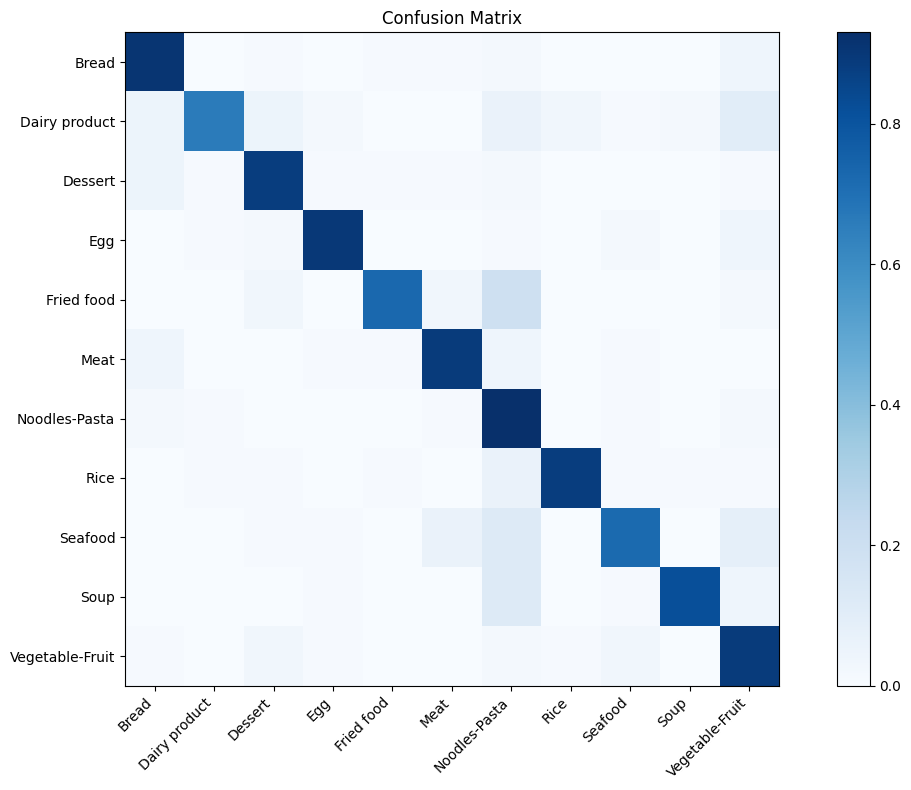

('                 precision    recall  f1-score   support\n\n          Bread       0.84      0.91      0.88       100\n  Dairy product       0.94      0.66      0.78       100\n        Dessert       0.85      0.88      0.86       100\n            Egg       0.93      0.90      0.91       100\n     Fried food       0.95      0.73      0.82       100\n           Meat       0.88      0.89      0.89       100\n  Noodles-Pasta       0.58      0.93      0.72       100\n           Rice       0.96      0.88      0.92       100\n        Seafood       0.88      0.72      0.79       100\n           Soup       0.96      0.82      0.89       100\nVegetable-Fruit       0.71      0.89      0.79       100\n\n       accuracy                           0.84      1100\n      macro avg       0.86      0.84      0.84      1100\n   weighted avg       0.86      0.84      0.84      1100\n',
 array([[91,  0,  1,  0,  1,  1,  2,  0,  0,  0,  4],
        [ 5, 66,  5,  2,  0,  0,  6,  3,  1,  2, 10],
        [ 5, 

In [22]:
# Valutazione di SqueezeNet sul test set
model = get_squeezenet_model()
model.load_state_dict(torch.load(path_modelli + "/squeezenet_finetuning_lr=0.0001/squeezenet_finetuning_lr=0.0001-30.pth", map_location=device))
y_pred, y_true = test_classifier(model, test_loader)
evaluate_classifier(y_pred, y_true, class_names)

c:\Users\giova\PythonEnvs\ml_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Classification Report ===
                 precision    recall  f1-score   support

          Bread       0.92      0.95      0.94       100
  Dairy product       0.95      0.93      0.94       100
        Dessert       0.96      0.97      0.97       100
            Egg       0.88      0.98      0.92       100
     Fried food       0.92      0.92      0.92       100
           Meat       0.97      0.95      0.96       100
  Noodles-Pasta       0.89      0.89      0.89       100
           Rice       0.89      0.95      0.92       100
        Seafood       0.87      0.86      0.86       100
           Soup       0.98      0.83      0.90       100
Vegetable-Fruit       0.94      0.91      0.92       100

       accuracy                           0.92      1100
      macro avg       0.92      0.92      0.92      1100
   weighted avg       0.92      0.92      0.92      1100

=== Matrice di confusione ===
[[95  0  2  0  1  0  0  0  1  0  1]
 [ 2 93  0  1  0  0  0  1  1  0  2]
 [ 0  1 97

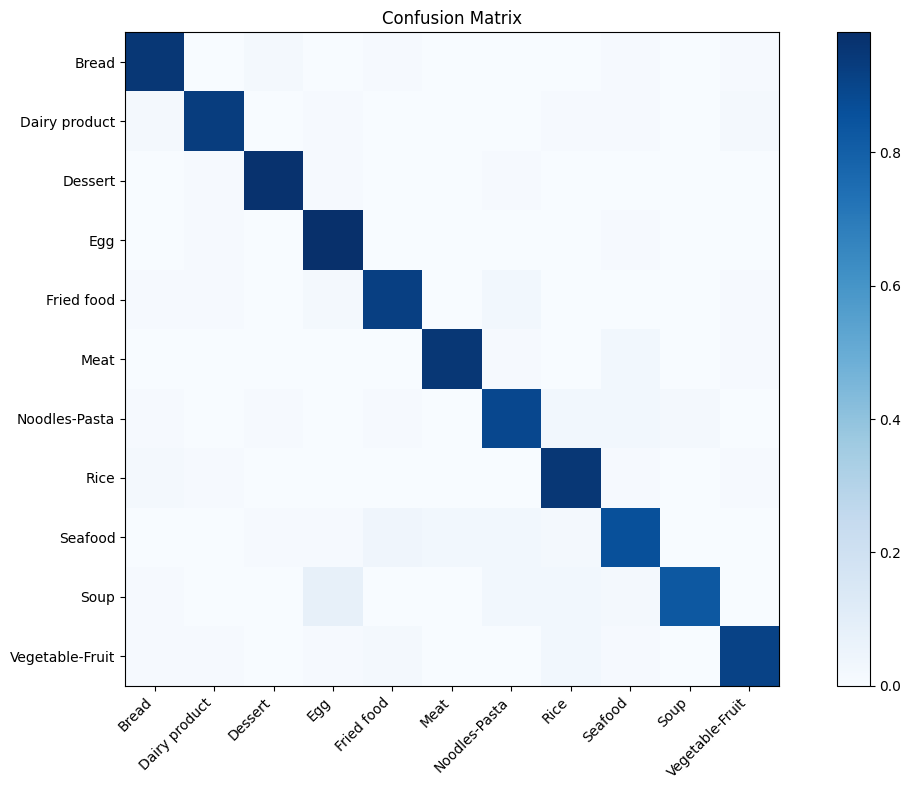

('                 precision    recall  f1-score   support\n\n          Bread       0.92      0.95      0.94       100\n  Dairy product       0.95      0.93      0.94       100\n        Dessert       0.96      0.97      0.97       100\n            Egg       0.88      0.98      0.92       100\n     Fried food       0.92      0.92      0.92       100\n           Meat       0.97      0.95      0.96       100\n  Noodles-Pasta       0.89      0.89      0.89       100\n           Rice       0.89      0.95      0.92       100\n        Seafood       0.87      0.86      0.86       100\n           Soup       0.98      0.83      0.90       100\nVegetable-Fruit       0.94      0.91      0.92       100\n\n       accuracy                           0.92      1100\n      macro avg       0.92      0.92      0.92      1100\n   weighted avg       0.92      0.92      0.92      1100\n',
 array([[95,  0,  2,  0,  1,  0,  0,  0,  1,  0,  1],
        [ 2, 93,  0,  1,  0,  0,  0,  1,  1,  0,  2],
        [ 0, 

In [23]:
# Valutazione di ResNet sul test set
model = get_resnet_model()
model.load_state_dict(torch.load(path_modelli + "/resnet_finetuning_lr=0.0001/resnet_finetuning_lr=0.0001-30.pth", map_location=device))
y_pred, y_true = test_classifier(model, test_loader)
evaluate_classifier(y_pred, y_true, class_names)

c:\Users\giova\PythonEnvs\ml_env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Classification Report ===
                 precision    recall  f1-score   support

          Bread       0.95      0.97      0.96       100
  Dairy product       0.94      0.96      0.95       100
        Dessert       0.97      0.95      0.96       100
            Egg       0.92      0.99      0.95       100
     Fried food       0.95      0.96      0.96       100
           Meat       0.99      0.98      0.98       100
  Noodles-Pasta       0.86      0.91      0.88       100
           Rice       0.94      0.97      0.96       100
        Seafood       0.90      0.86      0.88       100
           Soup       1.00      0.92      0.96       100
Vegetable-Fruit       0.95      0.88      0.91       100

       accuracy                           0.94      1100
      macro avg       0.94      0.94      0.94      1100
   weighted avg       0.94      0.94      0.94      1100

=== Matrice di confusione ===
[[97  0  0  0  0  0  0  0  2  0  1]
 [ 0 96  1  2  0  0  0  0  0  0  1]
 [ 1  1 95

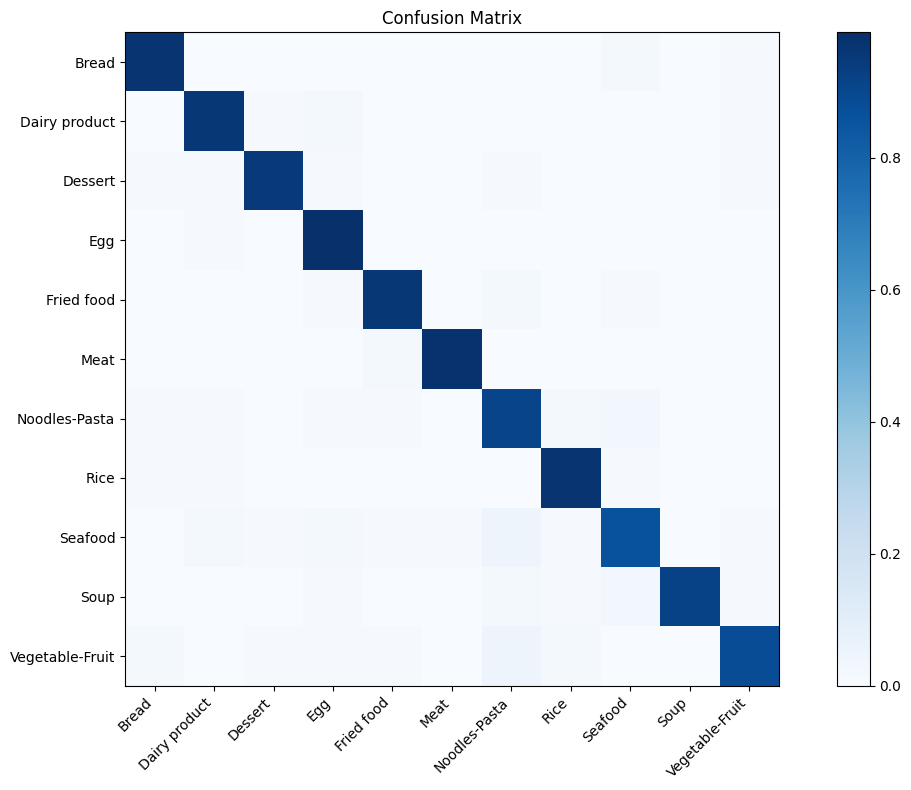

('                 precision    recall  f1-score   support\n\n          Bread       0.95      0.97      0.96       100\n  Dairy product       0.94      0.96      0.95       100\n        Dessert       0.97      0.95      0.96       100\n            Egg       0.92      0.99      0.95       100\n     Fried food       0.95      0.96      0.96       100\n           Meat       0.99      0.98      0.98       100\n  Noodles-Pasta       0.86      0.91      0.88       100\n           Rice       0.94      0.97      0.96       100\n        Seafood       0.90      0.86      0.88       100\n           Soup       1.00      0.92      0.96       100\nVegetable-Fruit       0.95      0.88      0.91       100\n\n       accuracy                           0.94      1100\n      macro avg       0.94      0.94      0.94      1100\n   weighted avg       0.94      0.94      0.94      1100\n',
 array([[97,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1],
        [ 0, 96,  1,  2,  0,  0,  0,  0,  0,  0,  1],
        [ 1, 

In [24]:
# Valutazione di EfficientNet sul test set
model = get_efficientnet_model()
model.load_state_dict(torch.load(path_modelli + "/efficientnet_finetuning_lr=0.0001/efficientnet_finetuning_lr=0.0001-30.pth", map_location=device))
y_pred, y_true = test_classifier(model, test_loader)
evaluate_classifier(y_pred, y_true, class_names)